# Analysis on XSum

Current structure:
* each metric has a DataFrame, df_metric
* df_metric has the score on all samples, from all models
* order of samples is consistent across different dfs, (i.e. different metrics)
* each df also has ordered labels

Correlations are of two types, as in this image:
* Sample Level
    * Take correlation b/w scores for models on EACH sample
    * Average over all samples

![sample](corr-sample.png)
![model](corr-model.png)

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
import os
import sys
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [4]:
xsumdir = '../xsum-200/aligned/'

df_r1 = pd.read_csv(os.path.join(xsumdir, 'df_rouge1.csv'))
df_r2 = pd.read_csv(os.path.join(xsumdir, 'df_rouge2.csv'))
df_rL = pd.read_csv(os.path.join(xsumdir, 'df_rougeL.csv'))

df_m1 = pd.read_csv(os.path.join(xsumdir, 'df_mvrs1.csv'))
# df_m2 = pd.read_csv(os.path.join(gigadir, 'df_mvrs2.csv'))

df_bs = pd.read_csv(os.path.join(xsumdir, 'df_berts.csv'))

In [5]:
df_r1.mean()

tconvs2s           0.312054
presumm_ext_abs    0.400075
presumm_abs        0.405948
pgn                0.298444
presumm_trans      0.313076
lead               0.162882
ext_oracle         0.298403
bart               0.454370
convs2s            0.314560
dtype: float64

In [6]:
df_m1.head()

,labels,tconvs2s,presumm_ext_abs,presumm_abs,pgn,presumm_trans,lead,ext_oracle,bart,convs2s
0,entity,0.199035,0.215831,0.206268,0.132864,0.246464,0.097501,0.182254,0.465297,0.215125
1,entity,0.244201,0.365522,0.300439,0.199302,0.162010,0.030195,0.030786,0.354292,0.181309
2,inference,0.084482,0.380270,0.335278,0.267441,0.254291,0.012882,0.188193,0.229864,0.061879
3,incomplete,0.071438,0.021492,-0.047175,-0.004587,0.038613,-0.097550,0.029548,0.021378,0.046235
4,inference,0.255988,0.376801,0.516303,0.221055,0.252287,0.126499,0.097904,0.331306,0.336889


In [7]:
from collections import Counter

In [8]:
Counter(df_m1.labels)

Counter({'entity': 42,
         'inference': 32,
         'incomplete': 1,
         'evidence': 23,
         'paraphrase': 22})

### Delete all rows where `label == 'incomplete'` 

In [9]:
for _cdf in [df_r1, df_r2, df_rL, df_m1, df_bs]:
    print(_cdf.shape)
    _cdf.drop(_cdf[_cdf['labels'] == 'incomplete'].index, inplace=True)
    print(_cdf.shape)
    print('='*25)

(120, 10)
(119, 10)
(120, 10)
(119, 10)
(120, 10)
(119, 10)
(120, 10)
(119, 10)
(120, 10)
(119, 10)


Counter({'entity': 42,
         'inference': 32,
         'incomplete': 1,
         'evidence': 23,
         'paraphrase': 22})

In [10]:
np.mean(df_m1.mean())

0.22065873449310752

In [11]:
by_label = df_m1.groupby('labels').mean()
by_label

,tconvs2s,presumm_ext_abs,presumm_abs,pgn,presumm_trans,lead,ext_oracle,bart,convs2s
labels,,,,,,,,,
entity,0.218375,0.338142,0.322106,0.209668,0.238803,0.089408,0.135035,0.370036,0.225889
evidence,0.188557,0.239000,0.223650,0.182815,0.190161,0.061170,0.103611,0.288005,0.182509
inference,0.227286,0.311338,0.303947,0.205229,0.230813,0.107975,0.148722,0.357090,0.227363
paraphrase,0.162403,0.238108,0.287451,0.160750,0.167778,0.099040,0.183055,0.365527,0.160057


In [12]:
avg_labels = by_label.mean(axis=1)
avg_labels

labels
entity        0.238607
evidence      0.184386
inference     0.235529
paraphrase    0.202686
dtype: float64

In [13]:
series_all = pd.Series([np.mean(df_m1.mean())], index=['all'])
series_all

all    0.220659
dtype: float64

In [14]:
avg_labels.append(series_all)

entity        0.238607
evidence      0.184386
inference     0.235529
paraphrase    0.202686
all           0.220659
dtype: float64

## Basic `bucket` analysis

In [16]:
mnames = ['rouge1', 'rouge2', 'rougeL', 'mvr1', 'berts']
mdfs = [df_r1, df_r2, df_rL, df_m1, df_bs]
mdatas = [x.values[:, 1:] for x in mdfs]

assert len(mnames) == len(mdfs)

In [17]:
overview = []

for name, df in zip(mnames, mdfs):
    score_models_full = df.mean()  # Mean across all samples, for each model => 1 x N_models
    score_avg = np.mean(score_models_full)  # Mean across all models  => 1 x 1
    
    gb_label = df.groupby('labels').mean()  # GB labels, mean across group samples, for each model => N_labels x N_models
    score_label = gb_label.mean(axis=1)  # In each group, mean across all models => N_labels x 1
    
    series_avg = pd.Series([score_avg], index=['all'])
    
    overview.append(score_label.append(series_avg))

In [18]:
score_avg

0.8774675716872976

In [19]:
overview[-1]

entity        0.881324
evidence      0.868014
inference     0.880226
paraphrase    0.875976
all           0.877468
dtype: float64

In [20]:
df_overview = pd.DataFrame(overview)
df_overview.index = mnames

In [21]:
df_overview.head()

,entity,evidence,inference,paraphrase,all
rouge1,0.340671,0.304131,0.352777,0.307516,0.330735
rouge2,0.139607,0.106384,0.142480,0.105378,0.127631
rougeL,0.276899,0.237483,0.290358,0.245234,0.267046
mvr1,0.238607,0.184386,0.235529,0.202686,0.220659
berts,0.881324,0.868014,0.880226,0.875976,0.877468


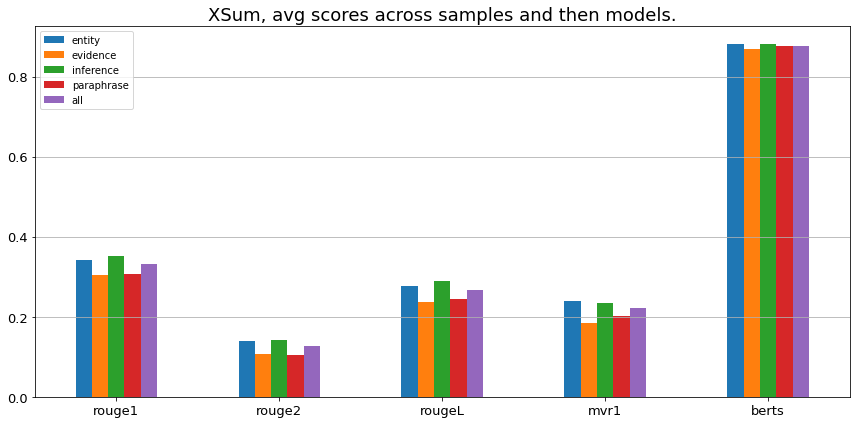

In [22]:
df_overview.plot.bar(rot=0, figsize=(12, 6), fontsize=13);
plt.title('XSum, avg scores across samples and then models.', fontsize=18)
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('overview_xsum_buckets.png')

In [38]:
ordered_cols = ['position', 'entity', 'evidence', 'paraphrase', 'inference', 'all']
groups_tikz = df_overview.round(2).copy()
groups_tikz['position'] = list(range(1, len(mnames)+1))
groups_tikz[ordered_cols].to_csv('./xsum_group_data.txt', index=False, header=False, sep=' ')

In [39]:
!cat ./xsum_group_data.txt

1 0.34 0.3 0.31 0.35 0.33
2 0.14 0.11 0.11 0.14 0.13
3 0.28 0.24 0.25 0.29 0.27
4 0.24 0.18 0.2 0.24 0.22
5 0.88 0.87 0.88 0.88 0.88


## System Rank correlations

In [23]:
import itertools
from collections import defaultdict

In [24]:
df_r1[df_r1.labels == 'entity'].head()

,labels,tconvs2s,presumm_ext_abs,presumm_abs,pgn,presumm_trans,lead,ext_oracle,bart,convs2s
0,entity,0.208333,0.097561,0.133333,0.163265,0.181818,0.040000,0.196078,0.500000,0.166667
1,entity,0.300000,0.463768,0.419355,0.271186,0.206897,0.071429,0.280702,0.515152,0.153846
7,entity,0.551724,0.486486,0.457143,0.400000,0.368421,0.121212,0.146341,0.424242,0.437500
9,entity,0.411765,0.324324,0.324324,0.250000,0.307692,0.272727,0.580645,0.352941,0.352941
11,entity,0.409091,0.521739,0.652174,0.489796,0.363636,0.250000,0.327869,0.595745,0.292683


In [25]:
df_m1[df_m1.labels == 'entity'].head()

,labels,tconvs2s,presumm_ext_abs,presumm_abs,pgn,presumm_trans,lead,ext_oracle,bart,convs2s
0,entity,0.199035,0.215831,0.206268,0.132864,0.246464,0.097501,0.182254,0.465297,0.215125
1,entity,0.244201,0.365522,0.300439,0.199302,0.162010,0.030195,0.030786,0.354292,0.181309
7,entity,0.273242,0.312334,0.293104,0.199908,0.244282,0.089895,0.034700,0.285322,0.206471
9,entity,0.384350,0.357945,0.282650,0.256121,0.199053,0.127280,0.282500,0.324493,0.284886
11,entity,0.171007,0.313360,0.363405,0.211168,0.201396,0.170230,0.151499,0.356627,0.144278


In [26]:
pearson_heatmap = np.eye(len(mnames))
spearman_heatmap = np.eye(len(mnames))

label_pear_heatmap = defaultdict(lambda : defaultdict(list))
label_sprm_heatmap = defaultdict(lambda : defaultdict(list))

ordered_labels = df_r1['labels'].tolist()

for m1, m2 in itertools.permutations(range(len(mnames)), 2):
    if m2 != m1:
        pearson_vals = []
        spearman_vals = []
        
        for i in range(df_r1.shape[0]):
            row1 = mdatas[m1][i].tolist()
            row2 = mdatas[m2][i].tolist()
            rowlabel = ordered_labels[i]
            
            pr_score, pr_pval = pearsonr(row1, row2)
            if not np.isnan(pr_score):
                pearson_vals.append(pr_score)
                label_pear_heatmap[rowlabel][(m1, m2)].append(pr_score)
                
            sm_score, sm_pval = spearmanr(row1, row2)
            if not np.isnan(sm_score):
                spearman_vals.append(sm_score)
                label_sprm_heatmap[rowlabel][(m1, m2)].append(sm_score)
                
        pearson_heatmap[m1, m2] = np.nanmean(pearson_vals)
        spearman_heatmap[m1, m2] = np.nanmean(spearman_vals)

/projects/anaconda3/envs/moverscore/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/projects/anaconda3/envs/moverscore/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [27]:
pearson_heatmap

array([[1.        , 0.83340055, 0.87169734, 0.82691692, 0.81796629],
       [0.83340055, 1.        , 0.86245732, 0.74497867, 0.74084473],
       [0.87169734, 0.86245732, 1.        , 0.75946702, 0.76489277],
       [0.82691692, 0.74497867, 0.75946702, 1.        , 0.90151354],
       [0.81796629, 0.74084473, 0.76489277, 0.90151354, 1.        ]])

In [40]:
with open('./xsum_pearson.npy', 'wb') as fp:
    np.save(fp, pearson_heatmap)

In [28]:
__old00__ = """
array([[1.        , 0.83106694, 0.87171486, 0.82644659],
       [0.        , 1.        , 0.8620672 , 0.74378903],
       [0.        , 0.        , 1.        , 0.75982968],
       [0.        , 0.        , 0.        , 1.        ]])
"""

In [29]:
spearman_heatmap

array([[1.        , 0.76813672, 0.82280804, 0.76944803, 0.76309212],
       [0.76813672, 1.        , 0.78942495, 0.69429262, 0.69029765],
       [0.82280804, 0.78942495, 1.        , 0.7038745 , 0.71596737],
       [0.76944803, 0.69429262, 0.7038745 , 1.        , 0.83787547],
       [0.76309212, 0.69029765, 0.71596737, 0.83787547, 1.        ]])

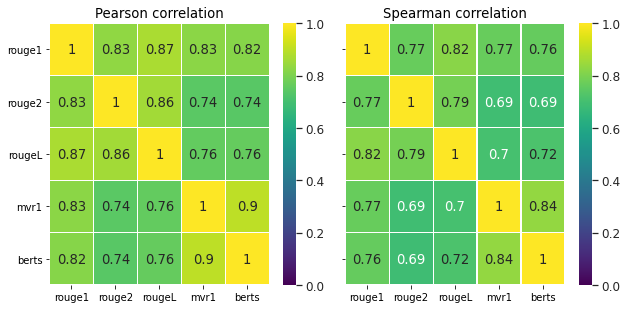

In [30]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# sns.set(font_scale=1.0)

# sns.heatmap(pearson_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax[0]);
# ax[0].set_title('Pearson correlation b/w model scores for metric pairs')

# sns.heatmap(spearman_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax[1]);
# ax[1].set_title('Spearman correlation b/w model scores for metric pairs')

# plt.tight_layout()
# plt.savefig('xsum_heatmaps_overview.png')


fig, ax = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)
sns.set(font_scale=1.1)

sns.heatmap(pearson_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, 
            annot=True, ax=ax[0], cmap='viridis', vmin=0, vmax=1);
ax[0].set_title('Pearson correlation')

for tick in ax[0].get_yticklabels():
    tick.set_rotation(0)

sns.heatmap(spearman_heatmap, xticklabels=mnames, yticklabels=mnames, linewidths=0.1,
            annot=True, ax=ax[1], cmap='viridis', vmin=0, vmax=1);
ax[1].set_title('Spearman correlation')

# sns.color_palette("viridis", as_cmap=True)

plt.tight_layout()
plt.savefig('xsum_heatmaps_overview.png')

### System Rank, `bucket` level

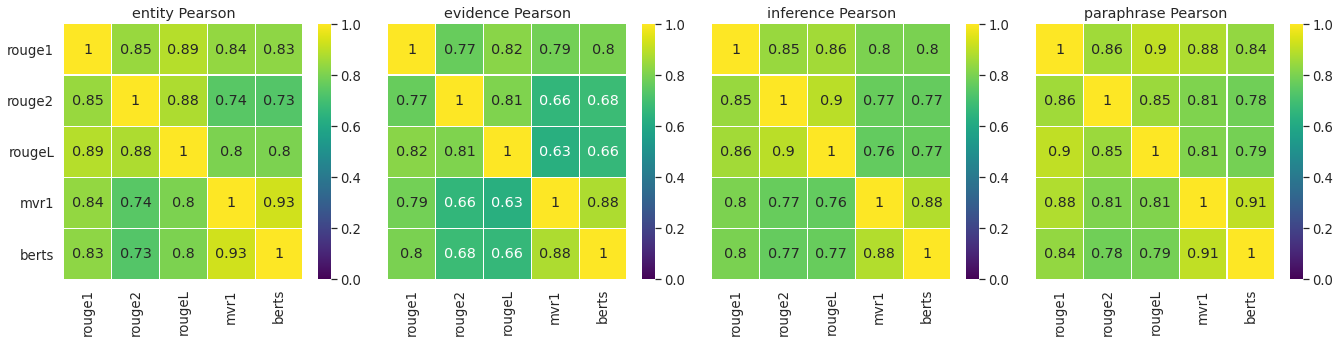

In [34]:
# fig, axes = plt.subplots(3, 2, figsize=(9, 12))
# axes = axes.flatten()
# i = 0
# for label, hmdata in sorted(label_pear_heatmap.items()):
#     subhm = np.eye(len(mnames))
#     ax = axes[i]
#     for (m1, m2), vals in hmdata.items():
#         subhm[m1, m2] = np.nanmean(vals)
        
#     sns.heatmap(subhm, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
#     ax.set_title('%s Pearson correlation' % label);
#     i += 1
    
# fig.tight_layout()
# fig.savefig('hm_labels_pearson.png')






fig, axes = plt.subplots(1, 4, figsize=(19, 5), sharey=True)
axes = axes.flatten()
i = 0

sns.set(font_scale=1.2)
for label, hmdata in sorted(label_pear_heatmap.items()):
    subhm = np.eye(len(mnames))
    ax = axes[i]
    for (m1, m2), vals in hmdata.items():
        subhm[m1, m2] = np.nanmean(vals)
        
    sns.heatmap(subhm, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, 
                annot=True, ax=ax, cmap='viridis', vmin=0, vmax=1);
    
    ax.set_title('%s Pearson' % label);
    i += 1
    

for tick in axes[0].get_yticklabels():
    tick.set_rotation(0)
    
fig.tight_layout()
fig.savefig('xsum_labels_pearson.png')

/projects/anaconda3/envs/moverscore/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


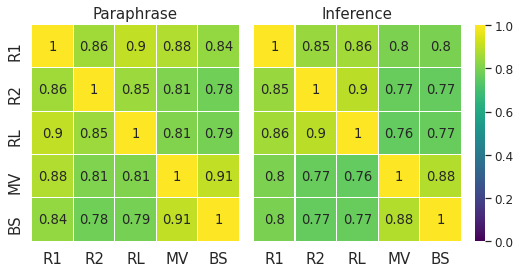

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(6.7, 4), sharey=True)
axes = axes.flatten()
i = 0

cbar_ax = fig.add_axes([1, 0.135, .02, 0.75])

# for label, hmdata in sorted(label_pear_heatmap.items()):
for label, hmdata in [('Paraphrase', label_pear_heatmap['paraphrase']),
                      ('Inference', label_pear_heatmap['inference'])]:
    subhm = np.eye(len(mnames))
    ax = axes[i]
    for (m1, m2), vals in hmdata.items():
        subhm[m1, m2] = np.nanmean(vals)
    
    ticklabels = ['R1', 'R2', 'RL', 'MV', 'BS']
    
    sns.set(font_scale=1.1)
    
    b = sns.heatmap(subhm, xticklabels=ticklabels, yticklabels=ticklabels, linewidths=0.1, 
            annot=True, ax=ax, cmap='viridis', vmin=0, vmax=1, 
                    cbar=True if i == 1 else False, cbar_ax=cbar_ax if i == 1 else None);
    
    b.set_xticklabels(ticklabels, size = 15)
    b.set_yticklabels(ticklabels, size = 15)
    
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    ax.set_title(label, fontsize=15);
    i += 1
    
fig.tight_layout()
fig.savefig('xsum_complexity_pearson.jpg', dpi=300, bbox_inches='tight')

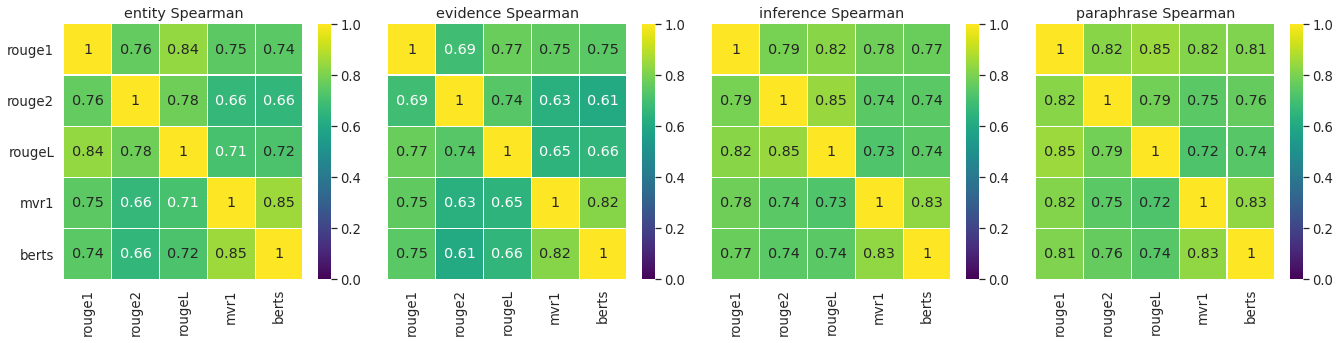

In [35]:
# fig, axes = plt.subplots(3, 2, figsize=(9, 12))
# axes = axes.flatten()
# i = 0
# for label, hmdata in sorted(label_sprm_heatmap.items()):
#     subhm = np.eye(len(mnames))
#     ax = axes[i]
#     for (m1, m2), vals in hmdata.items():
#         subhm[m1, m2] = np.nanmean(vals)
        
#     sns.heatmap(subhm, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
#     ax.set_title('%s Spearman correlation' % label);
#     i += 1
    
# fig.tight_layout()
# fig.savefig('hm_labels_spearman.png')



fig, axes = plt.subplots(1, 4, figsize=(19, 5), sharey=True)
axes = axes.flatten()
i = 0

sns.set(font_scale=1.2)
for label, hmdata in sorted(label_sprm_heatmap.items()):
    subhm = np.eye(len(mnames))
    ax = axes[i]
    for (m1, m2), vals in hmdata.items():
        subhm[m1, m2] = np.nanmean(vals)
        
    sns.heatmap(subhm, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, 
                annot=True, ax=ax, cmap='viridis', vmin=0, vmax=1);
    ax.set_title('%s Spearman' % label);
    i += 1
    
for tick in axes[0].get_yticklabels():
    tick.set_rotation(0)
    
fig.tight_layout()
fig.savefig('xsum_labels_spearman.png')

## Sample Correlation

In [38]:
samples_pearson = np.eye(len(mnames))
samples_spearman = np.eye(len(mnames))

samples_label_pear = defaultdict(lambda : np.eye(len(mnames)))
samples_label_sprm = defaultdict(lambda : np.eye(len(mnames)))

ordered_labels = df_r1['labels'].tolist()

for m1, m2 in itertools.combinations(range(len(mnames)), 2):
    if m2 > m1:
        over_pr = np.nanmean(
            [pearsonr(mdfs[m1][model], mdfs[m2][model])[0] for model in df_r1.columns[1:]]
        )
        samples_pearson[m1, m2] = over_pr
        
        over_sm = np.nanmean(
            [spearmanr(mdfs[m1][model], mdfs[m2][model])[0] for model in df_r1.columns[1:]]
        )
        samples_spearman[m1, m2] = over_sm
        
        tempdf1 = mdfs[m1]
        tempdf2 = mdfs[m2]
        for label in set(ordered_labels):
            subset_pr = np.nanmean(
                [pearsonr(tempdf1[tempdf1['labels'] == label][model], 
                          tempdf2[tempdf2['labels'] == label][model])[0] for model in df_r1.columns[1:]]
            )
            samples_label_pear[label][m1, m2] = subset_pr
            
            subset_sm = np.nanmean(
                [spearmanr(tempdf1[tempdf1['labels'] == label][model], 
                           tempdf2[tempdf2['labels'] == label][model])[0] for model in df_r1.columns[1:]]
            )
            samples_label_sprm[label][m1, m2] = subset_sm

In [39]:
label, subset_pr, subset_sm

('inference', 0.8011306063229363, 0.7696531616945831)

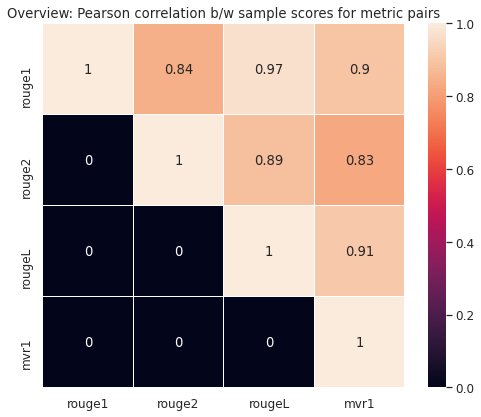

In [40]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.set(font_scale=1.1)
sns.heatmap(samples_pearson, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
ax.set_title('Overview: Pearson correlation b/w sample scores for metric pairs')
plt.tight_layout()
plt.savefig('hm_samples_pearson.png')

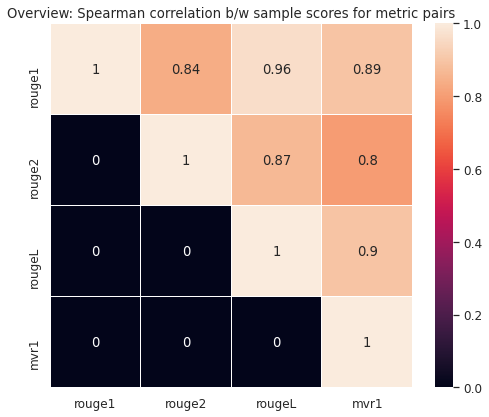

In [41]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.set(font_scale=1.1)
sns.heatmap(samples_spearman, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
ax.set_title('Overview: Spearman correlation b/w sample scores for metric pairs')
plt.tight_layout()
plt.savefig('hm_samples_spearman.png')

In [42]:
np.nanmean(
    [spearmanr(df_r1[df_r1.labels == 'extractive'][model], 
               df_m1[df_m1.labels == 'extractive'][model])[0] for model in df_r1.columns[1:]]
)

0.8524304081576979

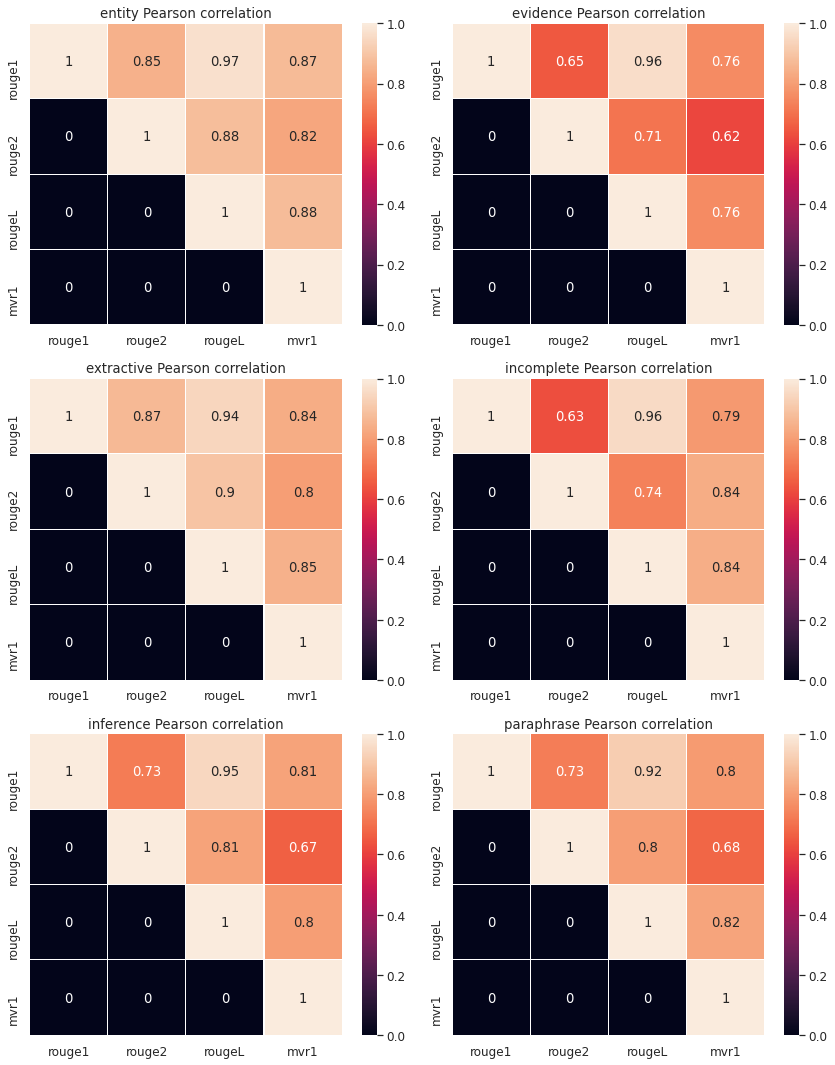

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()
i = 0
for label, hmdata in sorted(samples_label_pear.items()):
    ax = axes[i]
    sns.heatmap(hmdata, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
    ax.set_title('%s Pearson correlation' % label);
    i += 1
    
fig.tight_layout()
fig.savefig('hm_samples_labels_pearson.png')

In [44]:
label, hmdata

('paraphrase',
 array([[1.        , 0.72933312, 0.9210595 , 0.79549325],
        [0.        , 1.        , 0.80317932, 0.67720026],
        [0.        , 0.        , 1.        , 0.81729352],
        [0.        , 0.        , 0.        , 1.        ]]))

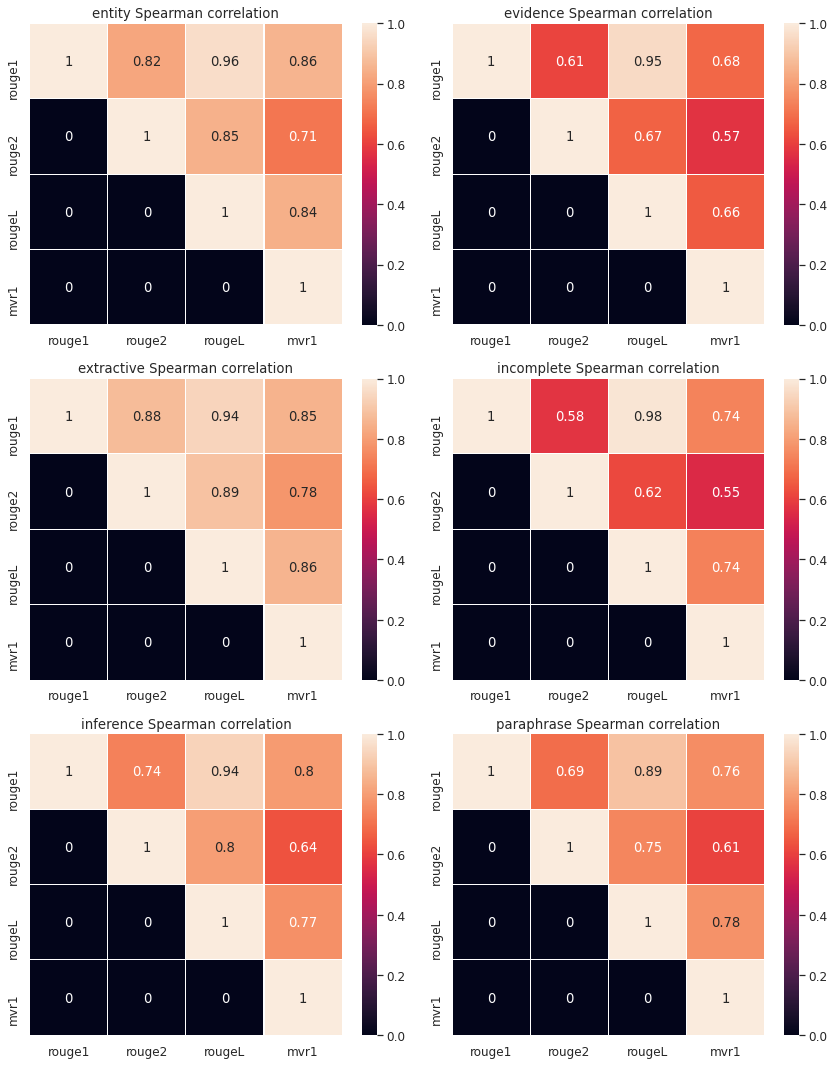

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()
i = 0
for label, hmdata in sorted(samples_label_sprm.items()):
    ax = axes[i]
    sns.heatmap(hmdata, xticklabels=mnames, yticklabels=mnames, linewidths=0.1, annot=True, ax=ax);
    ax.set_title('%s Spearman correlation' % label);
    i += 1
    
fig.tight_layout()
fig.savefig('hm_samples_labels_spearman.png')

In [38]:
np.round(samples_label_sprm['extractive'], 2)

array([[1.  , 0.89, 0.93, 0.84, 0.83],
       [0.  , 1.  , 0.9 , 0.8 , 0.78],
       [0.  , 0.  , 1.  , 0.84, 0.84],
       [0.  , 0.  , 0.  , 1.  , 0.99],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])

## Manual analysis